In [582]:
from PIL import Image
import numpy as np
import cv2
from scipy import signal as sig
from skimage.io import imread
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
from numpy import unravel_index

In [917]:
img = Image.open("box.jpg")

In [918]:
img = img.convert('RGB')

In [919]:
def imgtogray(img):
    img = np.array(img).astype('float64')
    img[:,:,0] *= 0.299
    img[:,:,1] *= 0.587
    img[:,:,2] *= 0.114
    return np.sum(img,axis=2).astype("uint8")

In [920]:
img_gray = imgtogray(img)
#img_gray = img.convert("LA")

In [921]:
# img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
# sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) # Sobel Edge
# sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3) # Sobel Edge
# sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3) # Sobel Edge

In [922]:
def sobel_edge_detector_cv2(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=3)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad_norm = (grad * 255 / grad.max()).astype(np.uint8)
    return grad_x, grad_y, grad, grad_norm

In [923]:
def sobel_edge_detector_scipy(img):
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = sig.convolve2d(img, kernel_x, mode='same')
    Ix_norm = (Ix * 255 / Ix.max()).astype(np.uint8)
    Iy = sig.convolve2d(img, kernel_y, mode='same')
    Iy_norm = (Iy * 255 / Iy.max()).astype(np.uint8)
    grad = np.sqrt(Ix**2 + Iy**2)
    Ixy_norm = (grad * 255 / grad.max()).astype(np.uint8)
    return Ix_norm, Iy_norm, Ixy_norm

In [924]:
def gaussian_blur_scipy(img):
    kernel = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])
    I = sig.convolve2d(img, kernel, mode='same')/16.0
    I_norm = (I * 255 / I.max()).astype(np.uint8)
    return I, I_norm

In [925]:
Ix,Iy,Ixy = sobel_edge_detector_scipy(img_gray)


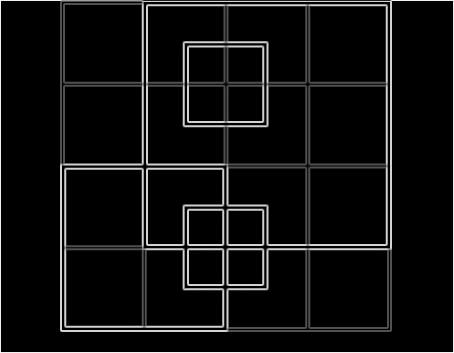

In [926]:
Image.fromarray(Ixy)

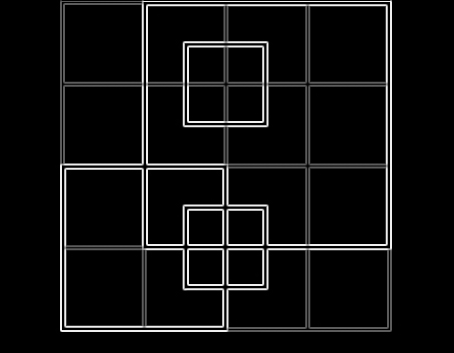

In [927]:
_,_,_,img_dif = sobel_edge_detector_cv2(img_gray)
Image.fromarray(img_dif)

In [928]:
Ixx = ndi.gaussian_filter(Ix**2, sigma=2)
Ixy = ndi.gaussian_filter(Ix*Iy, sigma=2)
Iyy = ndi.gaussian_filter(Iy**2, sigma=2)

In [929]:
Ixx,_ = gaussian_blur_scipy(Ix**2)
Ixy,_ = gaussian_blur_scipy(Ix*Iy)
Iyy,_ = gaussian_blur_scipy(Iy**2)

In [930]:
detM = Ixx * Iyy - Ixy**2
trM = Ixx + Ixy

In [931]:
alpha = 0.04
harris_response = detM - alpha * trM**2

In [932]:
harris_response.max()

18949.813125

In [933]:
harris_response.shape

(353, 454)

In [934]:
img.size

(454, 353)

In [935]:
# height = img_gray.shape[1]
# width = img_gray.shape[0]
# offset = 3

In [936]:
# for y in range(offset, height-offset):
#     for x in range(offset, width-offset):
#         Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
#         Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
#         Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
#         det = (Sxx * Syy) - (Sxy**2)
#         trace = Sxx + Syy
#         r = det - alpha*(trace**2)
        

In [937]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

In [938]:
for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < -5:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [255,0,0]

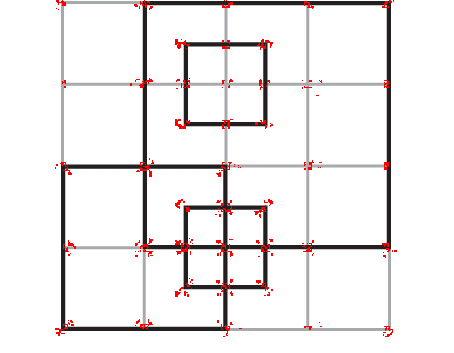

In [939]:
Image.fromarray(img_copy_for_corners)

In [940]:
np.where(harris_response ==1002.268125)

(array([0], dtype=int64), array([62], dtype=int64))

In [941]:
harris_response[0,62]

1002.268125

In [942]:
# harris_response[harris_response>1] = 255
# harris_response[harris_response<=1] = 0

In [943]:
harris_response[0:3,0:3]

array([[-1.24402500e+02, -2.60420313e+01,  0.00000000e+00],
       [-2.68475000e+01, -5.42281250e+00,  0.00000000e+00],
       [-1.00000000e-02, -2.50000000e-03,  0.00000000e+00]])

In [944]:
harris_response[0:3,0:3].max()

0.0

In [945]:
img_copy_for_corners = np.copy(img)
height = img_copy_for_corners.shape[0]
width = img_copy_for_corners.shape[1]
offset = 5
for x in range(offset, width+1):
    for y in range(offset, height+1):
        max_ind =  np.where(harris_response[y-offset:y,x-offset:x] == harris_response[y-offset:y,x-offset:x].max())
        max_x,max_y = max_ind[0][0], max_ind[1][0]
        if(harris_response[y-offset:y,x-offset:x][max_y,max_x]>200):
            img_copy_for_corners[y-offset:y,x-offset:x][max_y,max_x] = [255,0,0]
            
            
        else:
            harris_for_corners[y-offset:y,x-offset:x] = 255
        
        

In [946]:
height

353

In [947]:
len(harris_for_corners[harris_for_corners==0])

0

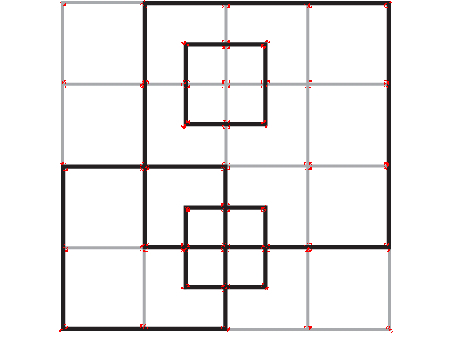

In [948]:
Image.fromarray(img_copy_for_corners)

In [871]:
harris_response[harris_response>20]=255
harris_response[harris_response<=20]=0

In [872]:
Image.fromarray(harris_response)

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=771x495 at 0x1AEDBAACE20>

In [332]:
new_p = Image.fromarray(harris_response)
if new_p.mode != 'RGB':
    new_p = new_p.convert('RGB')

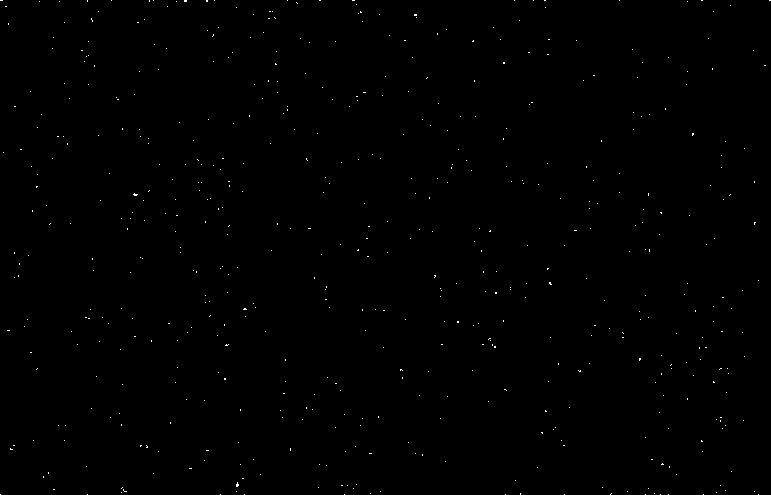

In [333]:
new_p

In [200]:
detM

array([[40.078125  , 15.078125  ,  0.        , ...,  0.        ,
         7.078125  ,  8.078125  ],
       [15.078125  ,  5.05859375,  0.        , ...,  0.        ,
         3.05859375,  7.078125  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 7.078125  ,  3.05859375,  0.        , ...,  0.        ,
         5.05859375, 15.078125  ],
       [ 8.078125  ,  7.078125  ,  0.        , ...,  0.        ,
        15.078125  , 40.078125  ]])